In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import shap
import joblib

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Load and Explore Data
# Load the dataset
df = pd.read_csv('D:/CreditFortify/data/loan_data.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())

print("\nFirst 5 rows:")
df.head()


Dataset Shape: (45000, 14)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
#Data Quality Assessment
print(" Missing Values:")
print(df.isnull().sum())

print("\nTarget Variable Distribution:")
print(df['loan_status'].value_counts())

print("\nTarget Variable Percentage:")
print(df['loan_status'].value_counts(normalize=True) * 100)

 Missing Values:
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

Target Variable Distribution:
loan_status
0    35000
1    10000
Name: count, dtype: int64

Target Variable Percentage:
loan_status
0    77.777778
1    22.222222
Name: proportion, dtype: float64


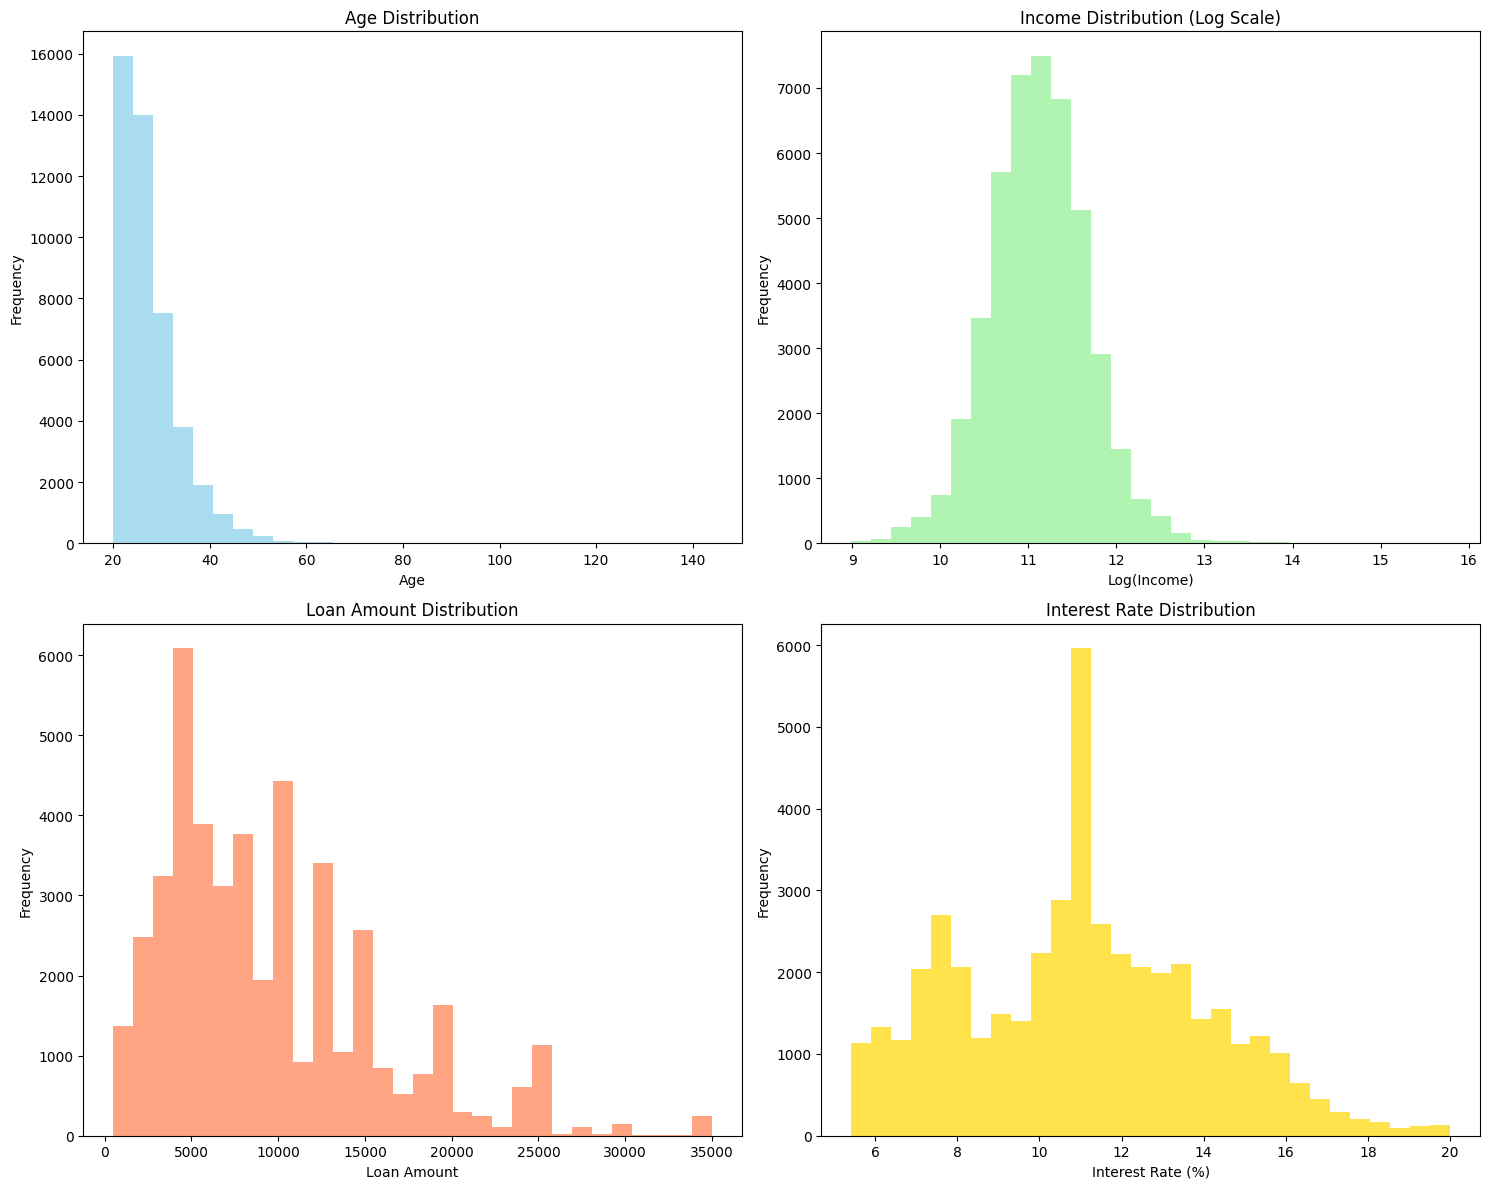

In [4]:
# Exploratory Data Analysis (EDA)
# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Age distribution
axes[0,0].hist(df['person_age'], bins=30, color='skyblue', alpha=0.7)
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Frequency')

# Income distribution (log scale)
axes[0,1].hist(np.log1p(df['person_income']), bins=30, color='lightgreen', alpha=0.7)
axes[0,1].set_title('Income Distribution (Log Scale)')
axes[0,1].set_xlabel('Log(Income)')
axes[0,1].set_ylabel('Frequency')

# Loan amount distribution
axes[1,0].hist(df['loan_amnt'], bins=30, color='coral', alpha=0.7)
axes[1,0].set_title('Loan Amount Distribution')
axes[1,0].set_xlabel('Loan Amount')
axes[1,0].set_ylabel('Frequency')

# Interest rate distribution
axes[1,1].hist(df['loan_int_rate'], bins=30, color='gold', alpha=0.7)
axes[1,1].set_title('Interest Rate Distribution')
axes[1,1].set_xlabel('Interest Rate (%)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


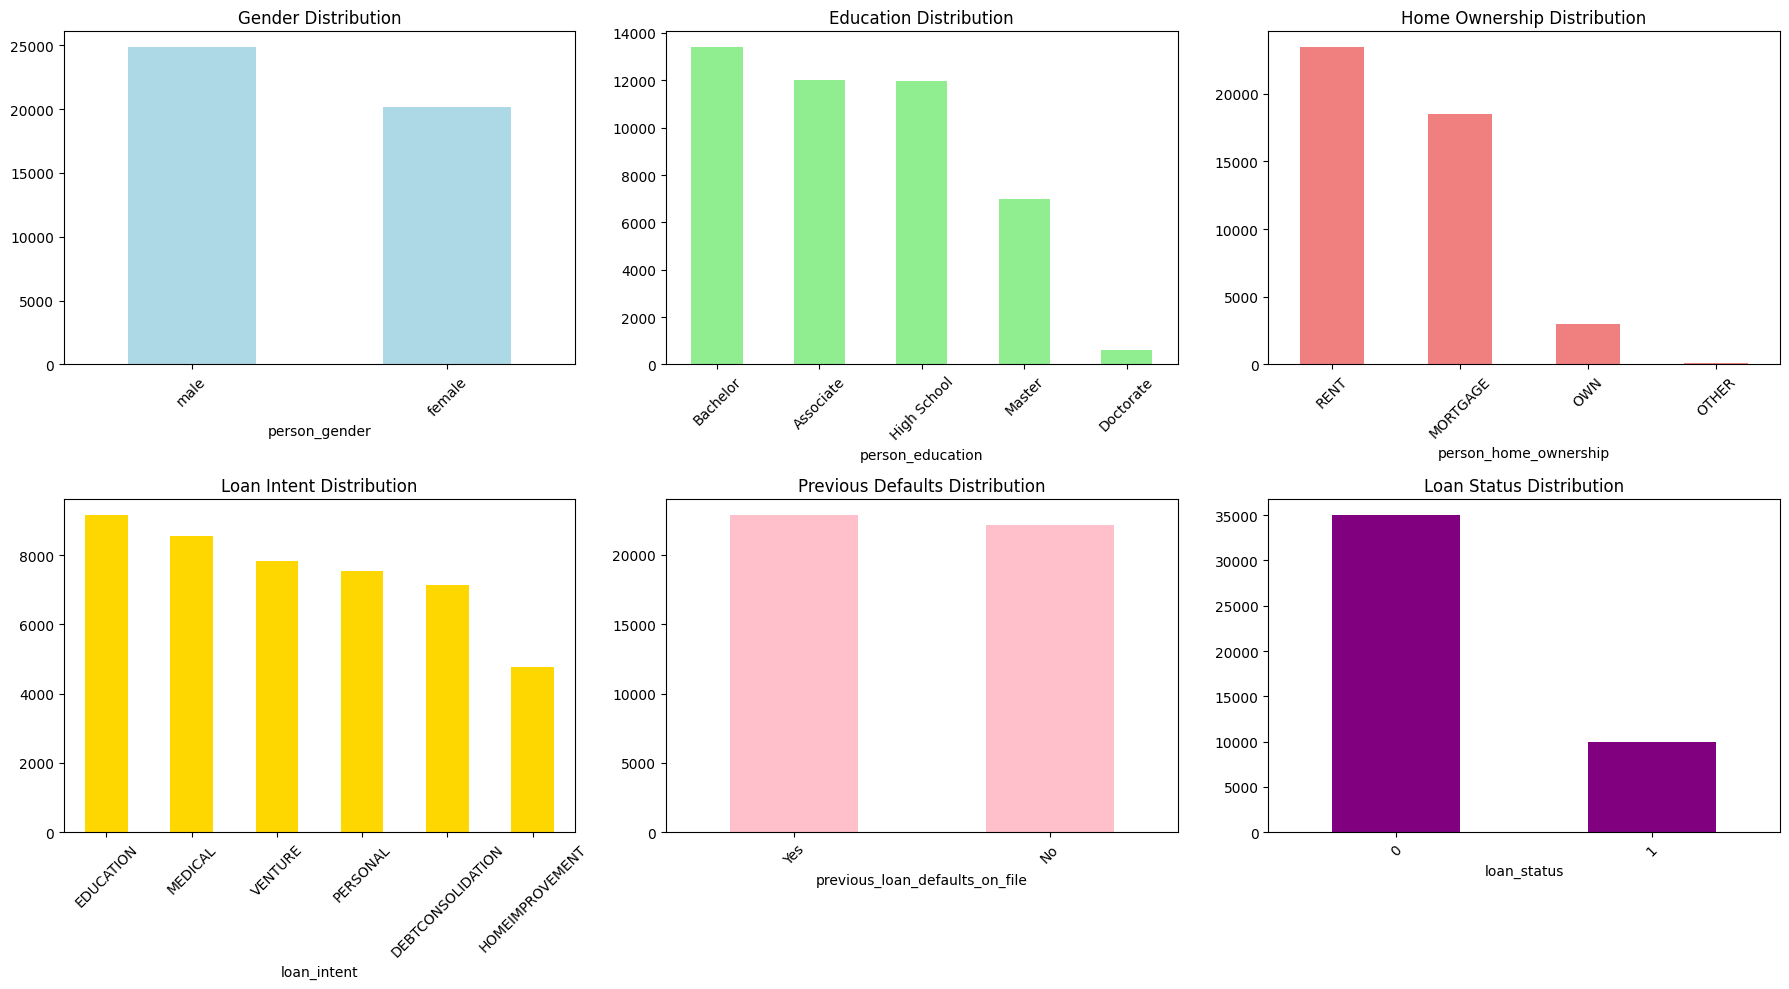

In [5]:
# Cell 5: Categorical Variables Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Gender distribution
df['person_gender'].value_counts().plot(kind='bar', ax=axes[0,0], color='lightblue')
axes[0,0].set_title('Gender Distribution')
axes[0,0].tick_params(axis='x', rotation=45)

# Education distribution
df['person_education'].value_counts().plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Education Distribution')
axes[0,1].tick_params(axis='x', rotation=45)

# Home ownership distribution
df['person_home_ownership'].value_counts().plot(kind='bar', ax=axes[0,2], color='lightcoral')
axes[0,2].set_title('Home Ownership Distribution')
axes[0,2].tick_params(axis='x', rotation=45)

# Loan intent distribution
df['loan_intent'].value_counts().plot(kind='bar', ax=axes[1,0], color='gold')
axes[1,0].set_title('Loan Intent Distribution')
axes[1,0].tick_params(axis='x', rotation=45)

# Previous defaults distribution
df['previous_loan_defaults_on_file'].value_counts().plot(kind='bar', ax=axes[1,1], color='pink')
axes[1,1].set_title('Previous Defaults Distribution')
axes[1,1].tick_params(axis='x', rotation=45)

# Target variable distribution
df['loan_status'].value_counts().plot(kind='bar', ax=axes[1,2], color='purple')
axes[1,2].set_title('Loan Status Distribution')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

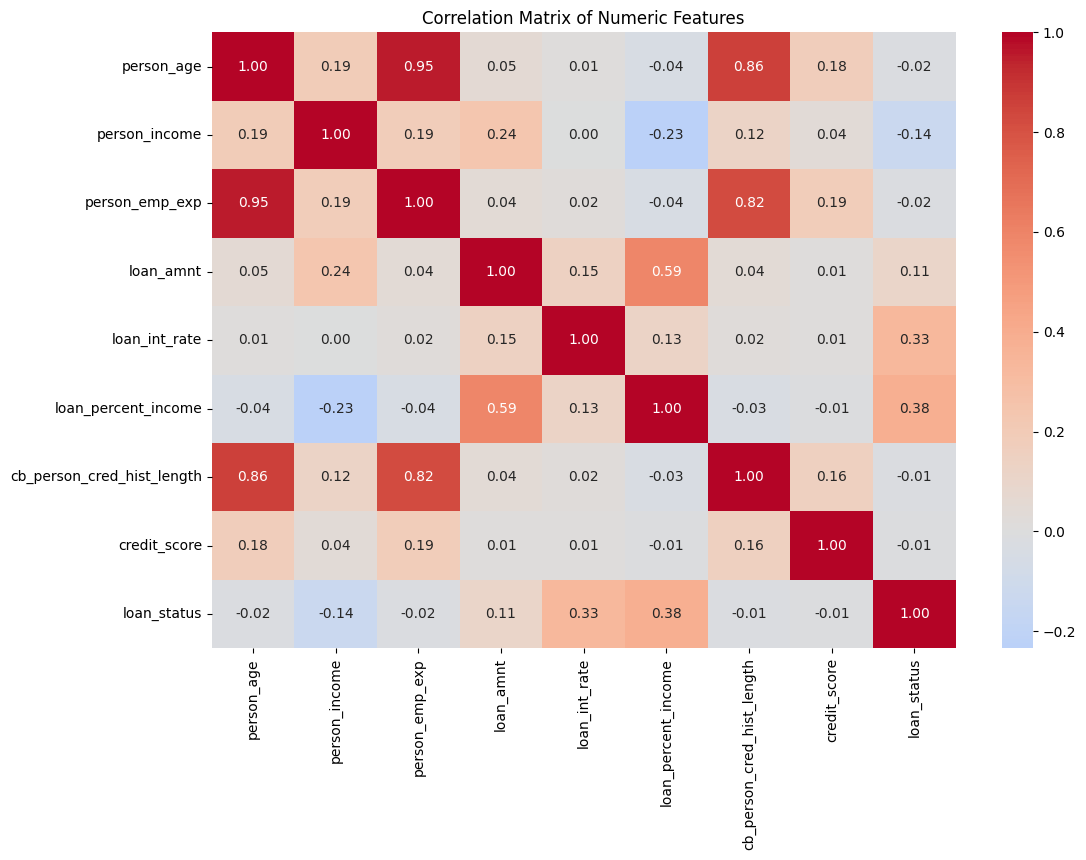

In [6]:
# Correlation Analysis
# Select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [7]:
# Data Preprocessing
# Create a copy for preprocessing
df_processed = df.copy()

# Handle outliers in income (cap at 99th percentile)
income_99th = df_processed['person_income'].quantile(0.99)
df_processed['person_income'] = df_processed['person_income'].clip(upper=income_99th)

# Handle outliers in age (reasonable range)
df_processed = df_processed[(df_processed['person_age'] >= 18) & (df_processed['person_age'] <= 100)]

# Handle outliers in employment experience
df_processed = df_processed[df_processed['person_emp_exp'] >= 0]

# Create new features
df_processed['income_to_loan_ratio'] = df_processed['person_income'] / df_processed['loan_amnt']
df_processed['age_group'] = pd.cut(df_processed['person_age'], 
                                   bins=[0, 25, 35, 45, 55, 100], 
                                   labels=['18-25', '26-35', '36-45', '46-55', '55+'])

print("Data preprocessing completed!")
print("Processed dataset shape:", df_processed.shape)

Data preprocessing completed!
Processed dataset shape: (44993, 16)


In [8]:

# Feature Engineering
# Separate features and target
X = df_processed.drop(['loan_status'], axis=1)
y = df_processed['loan_status']

# Identify categorical and numerical columns
categorical_features = ['person_gender', 'person_education', 'person_home_ownership', 
                       'loan_intent', 'previous_loan_defaults_on_file', 'age_group']
numerical_features = [col for col in X.columns if col not in categorical_features]

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)


Numerical features: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'income_to_loan_ratio']
Categorical features: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file', 'age_group']


In [9]:
# Cell 9: Create Preprocessing Pipeline
# Preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("Preprocessing pipeline created!")


Preprocessing pipeline created!


In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Training target distribution:")
print(y_train.value_counts(normalize=True))

Training set size: (35994, 15)
Test set size: (8999, 15)
Training target distribution:
loan_status
0    0.777741
1    0.222259
Name: proportion, dtype: float64


In [11]:
# Handle Class Imbalance with SMOTE
# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Apply SMOTE for handling imbalanced data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

print("After SMOTE - Training set size:", X_train_balanced.shape)
print("After SMOTE - Target distribution:")
unique, counts = np.unique(y_train_balanced, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{u}: {c} ({c/len(y_train_balanced)*100:.1f}%)")

After SMOTE - Training set size: (55988, 27)
After SMOTE - Target distribution:
0: 27994 (50.0%)
1: 27994 (50.0%)


In [12]:
# Model Training
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"\n Training {name}...")
    
    # Train model
    model.fit(X_train_balanced, y_train_balanced)
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    
    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    model_results[name] = {
        'model': model,
        'auc_score': auc_score,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f" {name} - AUC Score: {auc_score:.4f}")


 Training Logistic Regression...
 Logistic Regression - AUC Score: 0.9522

 Training Random Forest...
 Random Forest - AUC Score: 0.9720

 Training XGBoost...
 XGBoost - AUC Score: 0.9770

 Training LightGBM...
 LightGBM - AUC Score: 0.9745

 Training Gradient Boosting...
 Gradient Boosting - AUC Score: 0.9675


 Model Performance Ranking:
                 Model  AUC Score
2              XGBoost   0.976999
3             LightGBM   0.974475
1        Random Forest   0.972010
4    Gradient Boosting   0.967505
0  Logistic Regression   0.952245


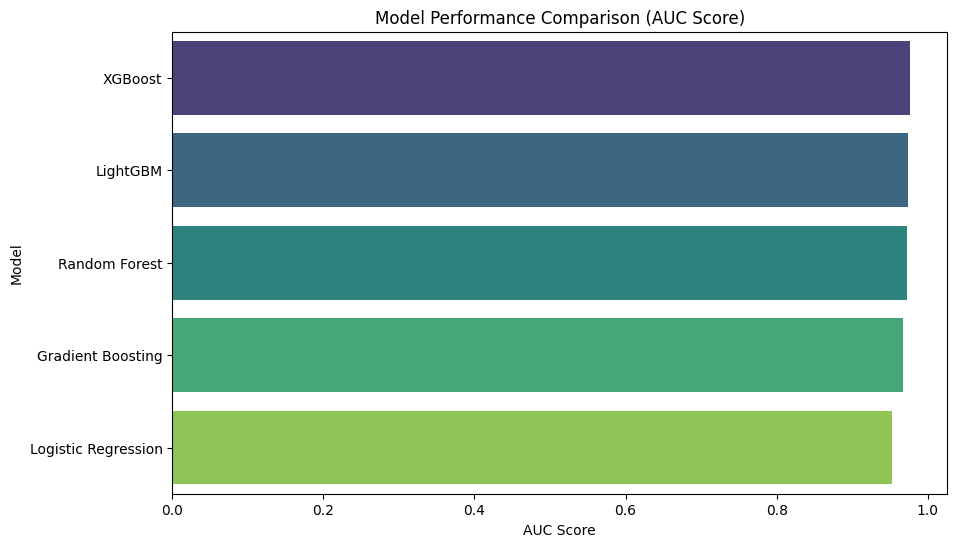

In [13]:
# Model Comparison
# Compare model performances
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'AUC Score': [results['auc_score'] for results in model_results.values()]
})

results_df = results_df.sort_values('AUC Score', ascending=False)
print(" Model Performance Ranking:")
print(results_df)

# Plot model comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='AUC Score', y='Model', palette='viridis')
plt.title('Model Performance Comparison (AUC Score)')
plt.xlabel('AUC Score')
plt.show()

 Best Model: XGBoost
 Best AUC Score: 0.9770

 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      6999
           1       0.86      0.84      0.85      2000

    accuracy                           0.93      8999
   macro avg       0.90      0.90      0.90      8999
weighted avg       0.93      0.93      0.93      8999



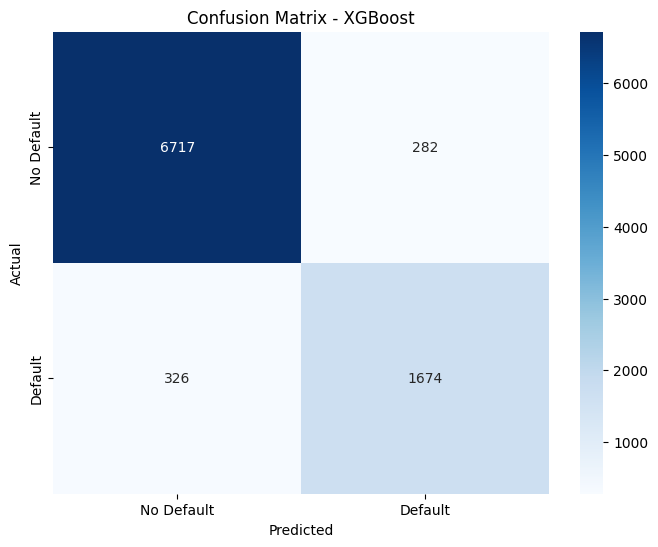

In [14]:
# Best Model Selection and Detailed Evaluation
best_model_name = results_df.iloc[0]['Model']
best_model = model_results[best_model_name]['model']
best_y_pred = model_results[best_model_name]['y_pred']
best_y_pred_proba = model_results[best_model_name]['y_pred_proba']

print(f" Best Model: {best_model_name}")
print(f" Best AUC Score: {model_results[best_model_name]['auc_score']:.4f}")

# Detailed classification report
print("\n Classification Report:")
print(classification_report(y_test, best_y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, best_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

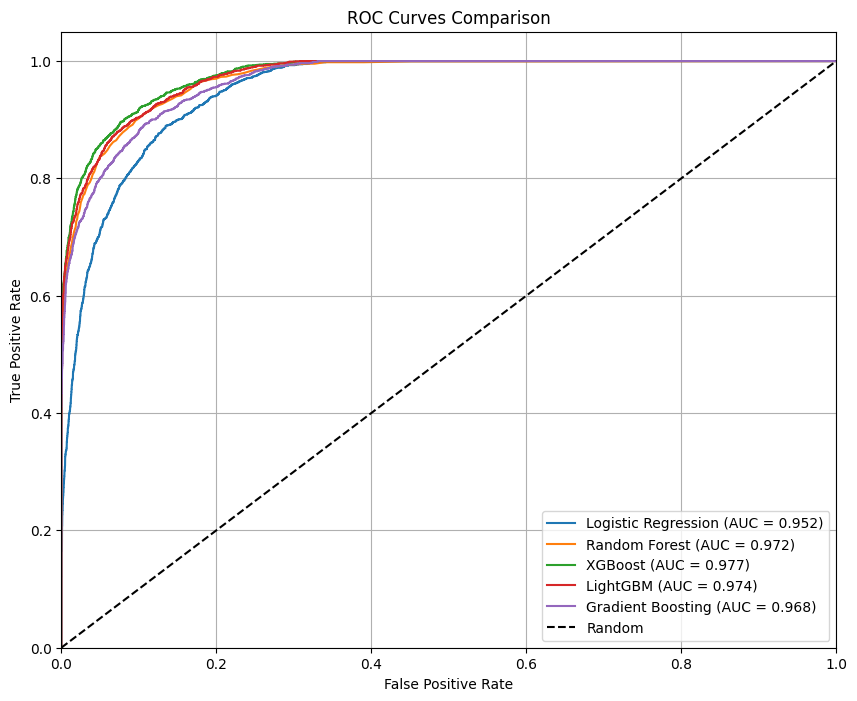

In [15]:
# ROC Curve Analysis
plt.figure(figsize=(10, 8))

for name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    auc_score = results['auc_score']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

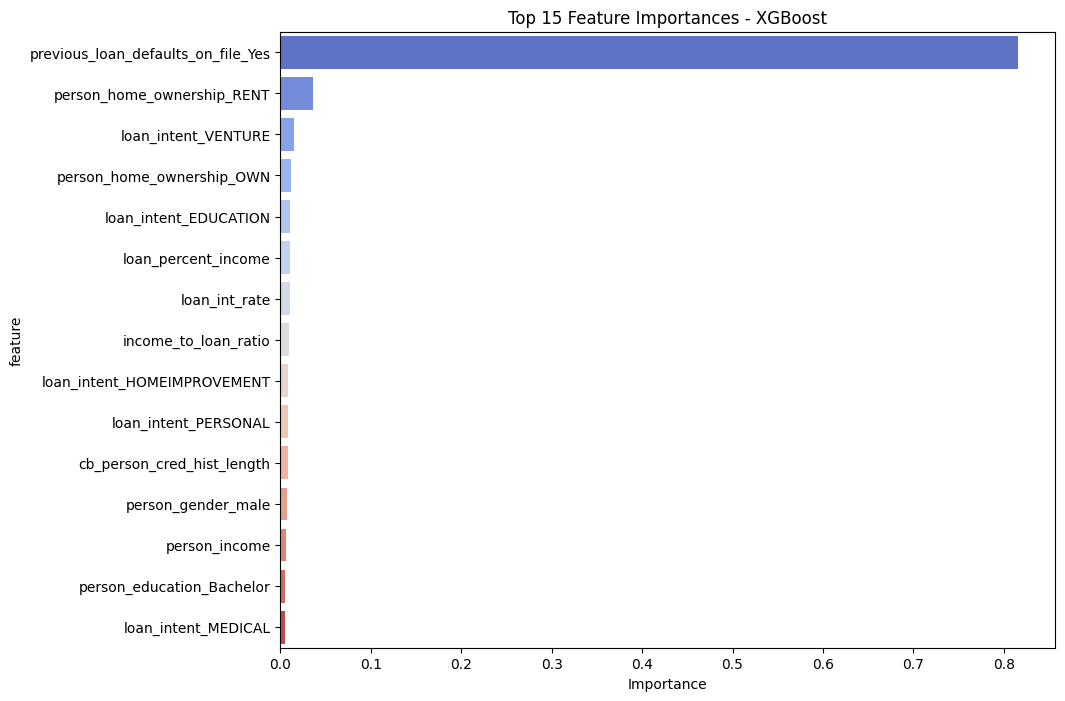

🔝 Top 10 Most Important Features:
                               feature  importance
22  previous_loan_defaults_on_file_Yes    0.816028
16          person_home_ownership_RENT    0.036326
21                 loan_intent_VENTURE    0.015681
15           person_home_ownership_OWN    0.011535
17               loan_intent_EDUCATION    0.010982
5                  loan_percent_income    0.010405
4                        loan_int_rate    0.010205
8                 income_to_loan_ratio    0.009558
18         loan_intent_HOMEIMPROVEMENT    0.008532
20                loan_intent_PERSONAL    0.008377


In [17]:
# Feature Importance Analysis
if hasattr(best_model, 'feature_importances_'):
    # Get feature names after preprocessing
    num_feature_names = numerical_features
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = num_feature_names + list(cat_feature_names)
    
    # Feature importance
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='coolwarm')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.show()
    
    print("🔝 Top 10 Most Important Features:")
    print(feature_importance_df.head(10))

In [18]:
# Save Models and Preprocessor
# Create models directory if it doesn't exist
import os
os.makedirs('../models', exist_ok=True)

# Save the best model
joblib.dump(best_model, '../models/best_model.pkl')

# Save the preprocessor
joblib.dump(preprocessor, '../models/preprocessor.pkl')

# Save feature names
joblib.dump(all_feature_names, '../models/feature_names.pkl')

# Save model results for later use
joblib.dump(model_results, '../models/model_results.pkl')

print("Models and preprocessor saved successfully!")
print(f"Best model ({best_model_name}) saved to: ../models/best_model.pkl")
print("Preprocessor saved to: ../models/preprocessor.pkl")


Models and preprocessor saved successfully!
Best model (XGBoost) saved to: ../models/best_model.pkl
Preprocessor saved to: ../models/preprocessor.pkl


In [19]:
#Model Performance Summary
print("="*60)
print(" CreditFortify - MODEL DEVELOPMENT SUMMARY")
print("="*60)
print(f" Dataset Size: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f" Best Model: {best_model_name}")
print(f" Best AUC Score: {model_results[best_model_name]['auc_score']:.4f}")
print(f" Class Balance: Original imbalanced → SMOTE balanced")
print(f" Features: {len(numerical_features)} numerical, {len(categorical_features)} categorical")
print(f" Models Saved: Yes")
print("="*60)

 CreditFortify - MODEL DEVELOPMENT SUMMARY
 Dataset Size: 45,000 rows, 14 columns
 Best Model: XGBoost
 Best AUC Score: 0.9770
 Class Balance: Original imbalanced → SMOTE balanced
 Features: 9 numerical, 6 categorical
 Models Saved: Yes


In [20]:
# Create Model Testing Function (CORRECTED)
def test_single_prediction(model, preprocessor, feature_names, sample_data):
    """
    Test model with a single prediction
    """
    try:
        # Convert to DataFrame if it's a dict
        if isinstance(sample_data, dict):
            sample_df = pd.DataFrame([sample_data])
        else:
            sample_df = sample_data.copy()
        
        # Ensure sample_df has all required columns in the correct order
        required_columns = X_train.columns.tolist()
        
        # Check for missing columns and add them with default values
        missing_cols = set(required_columns) - set(sample_df.columns)
        if missing_cols:
            print(f"Adding missing columns: {missing_cols}")
            for col in missing_cols:
                # Use the most common value or first value from training data
                if col in categorical_features:
                    sample_df[col] = X_train[col].mode()[0] if len(X_train[col].mode()) > 0 else X_train[col].iloc[0]
                else:
                    sample_df[col] = X_train[col].median()
        
        # Reorder columns to match training data
        sample_df = sample_df[required_columns]
        
        # Preprocess the data
        X_processed = preprocessor.transform(sample_df)
        
        # Make prediction
        prediction = model.predict(X_processed)[0]
        prediction_proba = model.predict_proba(X_processed)[0]
        
        return {
            'prediction': 'Default' if prediction == 1 else 'No Default',
            'probability': prediction_proba[1],
            'confidence': max(prediction_proba)
        }
    
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        return None

# Debug: Check what columns the preprocessor expects
print("Required columns for prediction:")
print("Training data columns:", X_train.columns.tolist())
print("Number of columns:", len(X_train.columns))

# Check unique values in categorical columns to avoid unknown categories
print("\n Valid values for categorical features:")
for col in categorical_features:
    print(f"{col}: {X_train[col].unique()}")

# Create sample with ALL required columns using valid values
sample_applicant = {
    'person_age': 35,
    'person_gender': X_train['person_gender'].iloc[0],  # Use valid value from training
    'person_education': X_train['person_education'].iloc[0],  # Use valid value from training
    'person_income': 50000,
    'person_emp_exp': 5,
    'person_home_ownership': X_train['person_home_ownership'].iloc[0],  # Use valid value from training
    'loan_amnt': 15000,
    'loan_intent': X_train['loan_intent'].iloc[0],  # Use valid value from training
    'loan_int_rate': 12.5,
    'loan_percent_income': 0.3,
    'cb_person_cred_hist_length': 8,
    'credit_score': 650,
    'previous_loan_defaults_on_file': X_train['previous_loan_defaults_on_file'].iloc[0],  # Use valid value
    'income_to_loan_ratio': 50000/15000,  # 3.33
    'age_group': '26-35'
}

print("\n Sample applicant data:")
for key, value in sample_applicant.items():
    print(f"{key}: {value}")

# Test the prediction
print("\n Testing prediction...")
result = test_single_prediction(best_model, preprocessor, all_feature_names, sample_applicant)

if result:
    print("\n Sample Prediction Test Successful!")
    print(f"Prediction: {result['prediction']}")
    print(f"Default Probability: {result['probability']:.3f}")
    print(f"Confidence: {result['confidence']:.3f}")
else:
    print("\n Sample prediction failed")

# Alternative: Create a completely safe sample using actual training data row
print("\n Testing with actual training data row...")
safe_sample = X_train.iloc[0].to_dict()

# Modify a few values for demonstration
safe_sample['person_age'] = 30
safe_sample['person_income'] = 45000
safe_sample['loan_amnt'] = 12000
safe_sample['income_to_loan_ratio'] = 45000/12000

safe_result = test_single_prediction(best_model, preprocessor, all_feature_names, safe_sample)

if safe_result:
    print(" Safe prediction successful!")
    print(f"Prediction: {safe_result['prediction']}")
    print(f"Default Probability: {safe_result['probability']:.3f}")
    print(f"Confidence: {safe_result['confidence']:.3f}")
else:
    print(" Safe prediction failed")

print("\n Model testing completed successfully!")


Required columns for prediction:
Training data columns: ['person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file', 'income_to_loan_ratio', 'age_group']
Number of columns: 15

 Valid values for categorical features:
person_gender: ['female' 'male']
person_education: ['Associate' 'Master' 'High School' 'Bachelor' 'Doctorate']
person_home_ownership: ['RENT' 'MORTGAGE' 'OWN' 'OTHER']
loan_intent: ['PERSONAL' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT' 'DEBTCONSOLIDATION'
 'EDUCATION']
previous_loan_defaults_on_file: ['Yes' 'No']
age_group: ['26-35', '18-25', '36-45', '46-55', '55+']
Categories (5, object): ['18-25' < '26-35' < '36-45' < '46-55' < '55+']

 Sample applicant data:
person_age: 35
person_gender: female
person_education: Associate
person_income: 50000
person_emp_exp: 5
person_home_owners